# Exploratory Data Analysis Notebook

## What is Pneuomonia?

- Pneumonia is an infection that <b>inflames air sacs</b> in one or both lungs, which may fill with fluid.
- With pneumonia, the <b>air sacs may fill with fluid or pus.</b> 
- The infection can be <b>life-threatening</b> to anyone, but particularly to infants, children and people over 65.

## What Exactly are we Predicting?

- The objective is to build an algorithm that can <b>detect visual signals for pneumonia</b> in medical images. 
- We do so by <b>predicting bounding boxes</b> around areas of the lung. 
- Samples <b>without</b> bounding boxes are <b>negative</b> and contain no definitive evidence of pneumonia. 
- Samples <b>with</b> bounding boxes <b>indicate evidence of pneumonia</b>.

## Format of Data

- <b><i>patientId_</i></b>- A patientId. Each patientId corresponds to a unique image.
- <b><i>x_</i></b> - the upper-left x coordinate of the bounding box.
- <b><i>y_</i></b> - the upper-left y coordinate of the bounding box.
- <b><i>width_</i></b> - the width of the bounding box.
- <b><i>height_</i></b> - the height of the bounding box.
- <b><i>Target_</i></b> - the binary Target, indicating whether this sample has evidence of pneumonia. (1 = true, 0 = false)

## Notes

- A pneumonia opacity is a part of the lungs that looks darker on a radiograph and has a shape that indicates that pneumonia is (or may be) present.
- Since the goal is to detect & then draw a bounding box on each pneumonia opacities (where each image can have 0 or many), and the training set is already classified:
    - It can be analysed as a supervised learning statistical multilabel classification


##### Classification Algorithms that can adapt to multi-label classification

- Boosting
- K nearest neighbours
- Decision Trees
- Kernel Methods
- Neural Networks

In [3]:
# Imports
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import pydicom

import os
from os import listdir
from os.path import isfile, join

In [14]:
pathLabels = "/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_labels.csv"
classInfo = "/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_detailed_class_info.csv"

labels = pd.read_csv(pathLabels)
classInfo = pd.read_csv(classInfo)

### Lets merge the classInfo & labels

In [32]:
merged = pd.merge(left = classInfo, right = labels, how = 'left', on = 'patientId') # Merge
merged = merged.drop_duplicates() # Remove duplicates

merged.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [39]:
# Shape
print(f"Number of unique patients: {merged.nunique()}")

Number of unique patients: patientId    26684
class            3
x              748
y              726
width          351
height         725
Target           2
dtype: int64


In [35]:
merged['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

###### We can see that over 20,000 people are classified as not having pneumonia, whereas around 10,000 people do

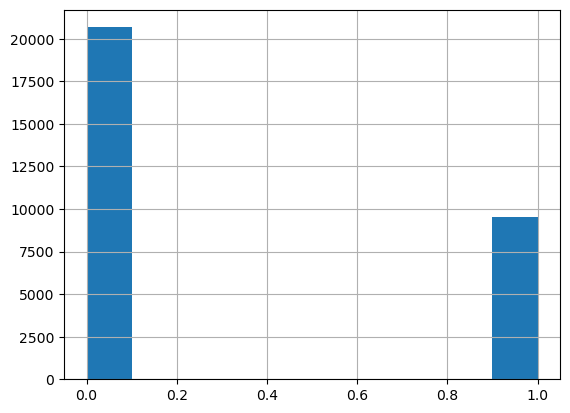

In [36]:
# See how many people with pneumonia vs non-pneumonia
merged['Target'].hist();

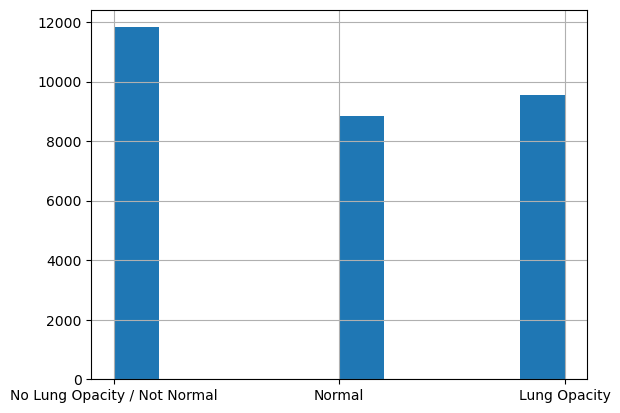

In [38]:
# Look at the amounts in each of the different classes
merged['class'].hist();

###### It seems that the amount is spread evenly between the 3 classes

### Check out pneumonia classifying boxes

In [56]:
boxNums = merged.dropna()[['x', 'y', 'width', 'height']].copy() # Make a copy of just the boxes

# Calculate x2 & y2 coordinates
boxNums['x2'] = boxNums['x'] + boxNums['width']
boxNums['y2'] = boxNums['y'] + boxNums['height']

# Calculate x2 & y2 centres
boxNums['xCentre'] = boxNums['x'] + boxNums['width']/2
boxNums['yCentre'] = boxNums['y'] + boxNums['height']/2

# Calculate area of the box
boxNums['boxArea'] = boxNums['width'] * boxNums['height']

In [55]:
boxNums.head()

,x,y,width,height,x2,y2,xCentre,yCentre,boxArea
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


In [40]:
trainImagesPath = '/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_images/'